<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            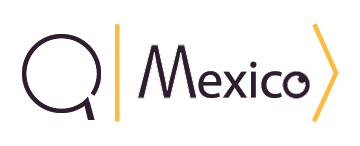
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Algoritmos cuánticos</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Diego Aguilar Muñoz</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Teleportación cuántica](#secc1)
   1. [Implementación en Qiskit](#secc1.1)
3. [Codificación superdensa](#secc2)
   1. [Implementación en Qiskit](#secc2.1)
4. [Algoritmo de Deutsch-Jozsa](#secc3)
   1. [Implementación en Qiskit](#secc3.1)
5. [Algoritmo de Grover](#secc4)
   1. [Implementación en Qiskit](#secc4.1)
7. [Referencias](#secc6)

<a id="intro"></a>
# Introducción

Un algoritmo es una serie de instrucciones utilizadas para realizar una serie de tareas bien definidas en una computadora. Al introducir la computación cuántica se empezaron a desarrollar nuevos algoritmos que realizaran tareas en tiempos mucho menores a lo que tomaría su algoritmo clásico equivalente. El propósito de este notebook será mostrar algunos de los algoritmos cuánticos más conocidos poniendo principal interés en su implementación en Qiskit.

In [1]:
import numpy as np
import random
import matplotlib
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize

# actualmente la versión de matplotlib usada por Qiskit 0.28.0 muestra un mensaje de advertencia (deprecation), 
# lo suprimimos por comodidad
import warnings
warnings.filterwarnings("ignore")

<a id="secc1"></a>
# Teleportación cuántica

Supongamos que tienes una amiga llamada Alice que tiene un qubit en el estado $\ket{\psi} = \alpha \ket{0} +\beta \ket{1}$ y se lo quiere mandar a su amigo Bob, esto implica pasar la información de $\alpha$ y $\beta$ a Bob. Sin embargo, el problema es que el teorema de no clonación de mecánica cuántica impide realizar una copia exacta de un estado desconocido. Es por esto que Alice no puede simplemente generar una copia y darsela a Bob. Sin embargo, con el apoyo de 2 bits clásicos y un par de qubits entrelazados, Alice puede mandar el estado $\ket{\psi}$ a Bob. Esto es conocido como el protocolo de teleportación.

Explicaremos el funcionamiento de este protocolo al mismo tiempo que lo implementamos en Qiskit para que sea más fácil su comprensión. Si quieres aprender de este protocolo con más detalle puedes consultar el siguiente <a href="https://qiskit.org/textbook/ch-algorithms/teleportation.html">enlace</a>.

<a id="secc1.1"></a>
## Implementación en Qiskit

Antes de comenzar a implementar el protocolo, debemos generar un estado aleatorio de un qubit para teleportar. Para esto debemos generar los parámetros $\theta$, $\lambda$ y $\phi$

In [2]:
# Parámetros aleatorios para definir el qubit a teleportar

theta = random.uniform(0, pi)
phi = random.uniform(0, 2*pi)
lam = 0

Debemos notar que en este caso vamos a requerir un sistema de 3 qubits (el qubit que queremos teleportar y 2 qubits entrelazados) y 2 bits clásicos que almacenarán la información que Bob recibirá. El primer paso será entrelazar los qubits para que tanto Bob como Alice reciban uno.

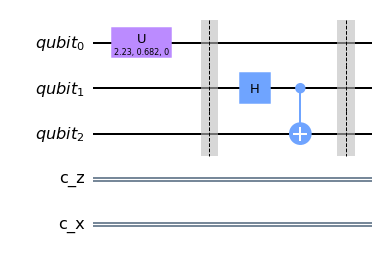

In [3]:
# Definimos nuestro circuito de 3 qubits y 2 bits
qr = QuantumRegister(3, name='qubit')
crz, crx = ClassicalRegister(1, name='c_z'), ClassicalRegister(1, name='c_x')
qc = QuantumCircuit(qr, crz, crx)

# Inicializamos el qubit que queremos mandar
qc.u(theta, phi, lam, 0)
qc.barrier(0,1,2)

# Entrelazamos los otros qubits
qc.h(1)
qc.cx(1,2)
qc.barrier(0,1,2)

# Visualizamos nuestro circuito
qc.draw(output='mpl')

Podemos observar los estados de cada uno de los qubits, en este caso debemos enfocarnos en el qubit 0 ya que ese será el estado que queremos enviar. 

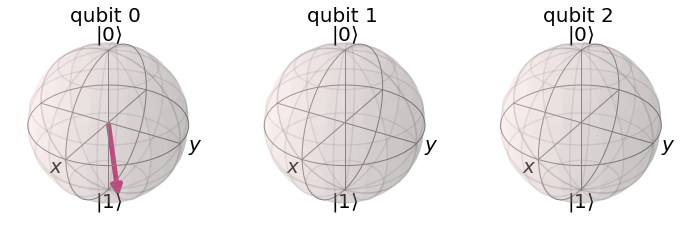

In [4]:
# Simulamos el vector de estado de nuestro sistema
state = Aer.get_backend('statevector_simulator')
result = execute(qc,state).result()
out_state = result.get_statevector()
plot_bloch_multivector(out_state)

El siguiente paso será que Alice aplica una compuerta *CNOT* controlada por el qubit 0 y con el qubit 1 como objetivo ya que estos son los qubits con los que ella puede trabajar. Finalmente aplica una compuerta *Hadamard* al qubit que quiere mandar (qubit 0) y realiza mediciones de cada uno de los qubits.

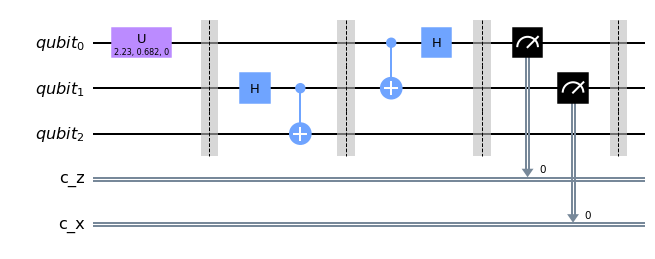

In [5]:
# Aplicamos una compuerta CNOT y una Hadamard
qc.cx(0,1)
qc.h(0)
qc.barrier(0,1,2)

# Medimos los 2 qubits de Alice
qc.measure([0,1],[0,1])
qc.barrier([0,1,2])

# Visualizamos nuestro circuito
qc.draw(output = 'mpl')

Alice tiene 4 posibles mediciones: 00, 01, 10 y 11. Una vez tomada esta medición, mediante un canal clásico enviará este resultado a Bob para que, dependiendo de la medición, Bob aplique las compuertas correspondientes a su qubit:

* **00**: No aplica ninguna compuerta
* **01**: Aplica una compuerta *X*
* **10**: Aplica una compuerta *Z*
* **11**: Aplica tanto una compuerta *X* como una compuerta *Z*

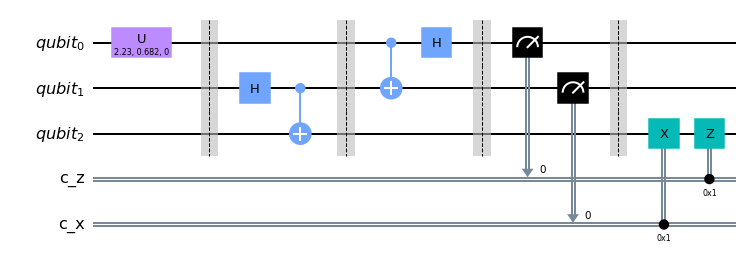

In [6]:
# Condicionamos una compuerta X si la medición del primer qubit es 1
qc.x(2).c_if(crx, 1)

# Condicionamos una compuerta Z si la medición del segundo qubit es 1
qc.z(2).c_if(crz, 1)

# Visualizamos nuestro circuito
qc.draw(output = 'mpl')

Con estos pasos Alice ha logrado teleportar su qubit a Bob. Solo resta simular los vectores de estado de nuestro sistema para comprobar que el estado del qubit 2 es el mismo que originalmente teníamos en el qubit 0.

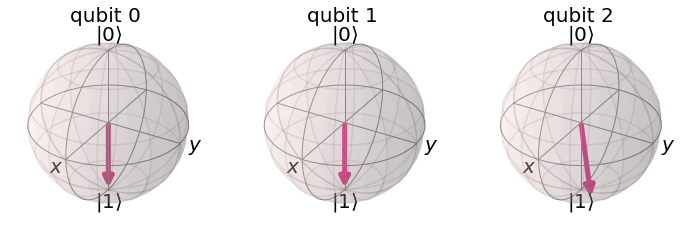

In [7]:
# Simulamos y visualizamos nuestros vectores de estado
state = Aer.get_backend('statevector_simulator')
result = execute(qc,state).result()
out_state = result.get_statevector()
plot_bloch_multivector(out_state)

<a id="secc2"></a>
# Codificación superdensa

Otro protocolo muy interesante que podemos analizar es la codificación cuántica densa. En este caso, Alice tiene un par de bits clásicos que quiere mandar a Bob, pero no quiere usar un canal de comunicación clásico. La codificación cuántica densa nos permite enviar ambos bits clásicos al mismo tiempo codificándolos en un qubit. Para este protocolo vamos a requerir de un par de qubits entrelazados. Donde inicialmente Alice tiene uno y Bob el otro. Pero para que Bob pueda obtener la información va a requerir que Alice le envíe su qubit después de codificarlo.

Explicaremos el funcionamiento de este protocolo al mismo tiempo que lo implementamos en Qiskit para que sea más fácil su comprensión. Si quieres aprender de este protocolo con más detalle puedes consultar el siguiente <a href="https://qiskit.org/textbook/ch-algorithms/superdense-coding.html">enlace</a>.

<a id="secc2.1"></a>
## Implementación en Qiskit

Lo primero que podemos hacer es definir los qubits que Alice quiere mandar

In [8]:
# Definimos los bits clásicos que Alice quiere enviar a Bob
c1 = 0
c0 = 1

El siguiente paso para empezar el protocolo será definir un circuito de 2 qubits y entrelazarlos.

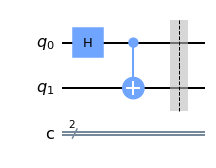

In [9]:
# Definimos el circuito de 2 qubits
qc = QuantumCircuit(2, 2)

# Entrelazamos nuestros qubits
qc.h(0)
qc.cx(0,1)
qc.barrier(0,1)

# Visualizamos nuestro circuito
qc.draw(output='mpl')

Dependiendo del mensaje que Alice quiera mandar, deberá aplicar una serie de compuertas lógicas a su qubit para codificar el mensaje. Si Alice quiere enviar:

* **00**: No aplica ninguna compuerta
* **01**: Aplica una compuerta *Z*
* **10**: Aplica una compuerta *X*
* **11**: Aplica una compuerta *Z* seguida por una compuerta *X*

In [10]:
# Condicionamos la compuerta Z si el primer bit que Alice quiere mandar es 1
if c0 == 1:
    qc.z(0)

# Condicionamos la compuerta X si el segundo bit que Alice quiere mandar es 1
if c1 == 1:
    qc.x(0)
    
qc.barrier([0,1])

El siguiente paso sería que Alice envíe su qubit a Bob, sin embargo esto nos lo tenemos que imaginar ya que, al ser una simulación, no podemos hacer una separación física de los qubits. Cuando Bob tenga los 2 qubits, el siguiente paso será aplicar una compuerta *CNOT* seguida por una compuerta *Hadamard* para eliminar el entrelazamiento y poder medir los bits codificados por Alice

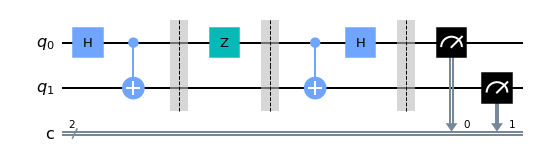

In [11]:
# Aplicamos una compuerta CNOT seguido por una Hadamard para eliminar el entrelazamiento
qc.cx(0,1)
qc.h(0)
qc.barrier([0,1])

#Medimos los qubits para obtener el mensaje de Alice
qc.measure([0,1],[0,1])

# Visualizamos nuestro circuito
qc.draw(output='mpl')

Para completar esta simulación podemos simular nuestro circuito y verificar que la medición sea lo que habíamos definido como el mensaje de Alice

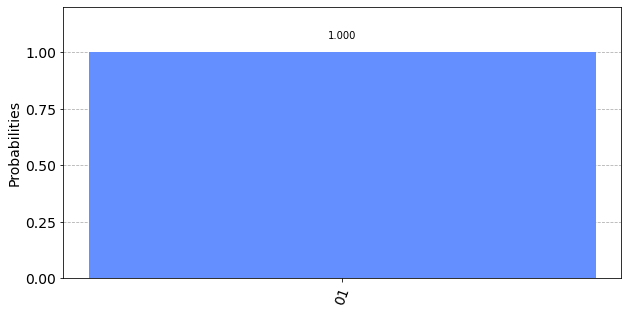

In [12]:
# Ejecutamos el ciruito
qasm = Aer.get_backend('qasm_simulator')
job = execute(qc, qasm, shots=1000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts,figsize=(10,5))

Ahora que conocemos los primeros 2 protocolos que cubre este notebook, podemos notar que ambos son muy parecidos ya que tienen como base un concepto fundamental del cómputo cuántico como lo es el estrelazamiento. Sin embargo, ambos realizan tareas muy diferentes, por un lado el protocolo de teleportación el objetivo es transmitir un qubit utilizando 2 bits clásicos. Por otro lado, la codificación superdensa nos perminte transpitir 2 bits clásicos por medio de un qubit.

<a id="secc3"></a>
# Algoritmo de Deutsch-Jozsa

Empecemos considerando una función $f(x)$ que toma como argumento una serie de bits y puede tomar los valores $0$ o $1$. A pesar de no conocer explicitamente esta función sabemos que puede ser de 2 tipos: balanceada o constante. Si es constante significa que no importa la cadena de bits que reciba, la salida siempre será la misma ($0$ o $1$). Si la función es balanceada, la mitad de los argumentos que se ingresen regresarán $0$ y la otra mitad regresarán $1$. Para conocer qué tipo de función, se utiliza el algoritmo de Deutsch-Jozsa.

Supongamos que la función $f(x)$ toma n bits como argumento, por lo que el estado inicial que vamos a utilizar va a constar de $n+1$ qubits, donde los primeros n están en $\ket{0}$ y el último está en $\ket{1}$. El siguiente paso es aplicar compuertas Hadamard a todos los qubits por lo que se tiene:

$$\begin{align*} \ket{\psi} & = (H^{\otimes n})(\ket{0}^{\otimes n}) \otimes (H\ket{1}) \\ & = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} \ket{x} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right) \end{align*} $$

El siguiente paso es aplicar el operador $U_f$ que está dado por $U_f\ket{x,y} = \ket{x,y \oplus f(x)}$ para evaluar la función. Los primeros n qubits serán los valores de $x$ y el último será $y$, por lo que el estado final es:

$$\ket{\psi '} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} (-1)^{f(x)} \ket{x} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)$$

Ahora podemos aplicar una compuerta Hadamard a los primeros n qubits de manera que:

$$ H^{\otimes n}\ket{x} = \frac{1}{\sqrt{2^n}} \sum_y (-1)^{xy} \ket{y} $$

Por lo que el estado final es:

$$ \ket{\psi_{final}} = \frac{1}{2^n} \sum_y \sum_x (-1)^{xy + f(x)} \ket{y} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right) $$

Finalmente podemos medir los n primeros qubits y tenemos 2 posibles resultados:

* Si al medir los primeros n qubits todos son $0$. Tenemos una función constante

* Si al medir por lo menos uno de los resultados es 1. Tenemos una función balanceada

Si quieres más detalles sobre este algoritmo puedes checar el siguiente <a href="https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html">enlace</a>.

<a id="secc3.1"></a>
## Implementación en Qiskit

En este caso vamos a aplicar el algoritmo de Deutsch-Josza a 2 diferentes funciones: una función constante y una balanceada. En ambos casos la función que vamos a implementar es para el caso que toma una entrada de 3 bits. El primer paso va a ser definir el oráculo ("caja negra" sobre el cual vamos a aplicar el algoritmo) de cada uno de estos ejemplos. Empecemos con el oráculo para una función constante, en este caso la entrada no va a tener efecto sobre la salida, por lo que podemos definir la salida como un conjunto aleatorio de compuertas *X* para que nuestro qubit de salida sea 0 o 1 y represente la constante 0 o 1 respectivamente.

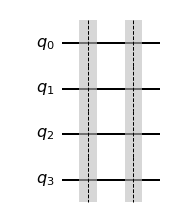

In [13]:
# Definimos el número de bits en la entrada de la función
n = 3

# Definimos el oráculo constante
oraculo_const = QuantumCircuit(n+1)

# Aplicamos compuertas X de manera aleatoria
oraculo_const.barrier()
aleatorio = np.random.randint(2)
if aleatorio == 1:
    oraculo_const.x(n)
oraculo_const.barrier()

# Visualizamos nuestro oráculo
oraculo_const.draw(output='mpl')

El siguiente paso va a ser definir nuestro oráculo para una función balanceada. Lo primero que debemos hacer es inicializar nuestros qubits de entrada a la cadena de bits que hayamos decidido ingresar, en este caso podemos utilizar la cadena $101$. Para esto, debemos aplicar una compuerta *X* sobre cada uno de los qubits que correspondan a un bit igual a 1, en este caso el primer y el tercer qubit. Puedes modificar la cadena de entrada de la función para observar como cambia el circuito, El siguiente paso es aplicar una compuerta *CNOT* para cada qubit de entrada y teniendo como objetivo el qubit de salida. Finalmente, debemos reiniciar nuestros qubits de entrada al estado $\ket{0}$, por lo que volvemos a aplicar una compuerta *X* a los qubits que correspondan a un bit igual a 1. 

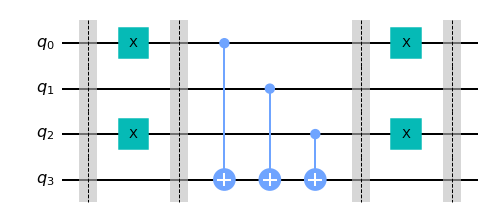

In [14]:
# Definimos nuestro oráculo de n+1 qubits
oraculo_balanceado = QuantumCircuit(n+1)

# Definimos la cadena de entrada de la función
entrada = "101"

# Aplicamos compuertas X sobre los qubits correspondientes a un bit igual a 1
oraculo_balanceado.barrier()
for qubit in range(len(entrada)):
    if entrada[qubit] == '1':
        oraculo_balanceado.x(qubit)

oraculo_balanceado.barrier()

# Aplicamos compuertas CNOT con cada uno de los qubits de entrada como control y el qubit de salida como objetivo
for qubit in range(n):
    oraculo_balanceado.cx(qubit, n)

# Reiniciamos nuestros qubits de entrada al estado |0>
oraculo_balanceado.barrier()
for qubit in range(len(entrada)):
    if entrada[qubit] == '1':
        oraculo_balanceado.x(qubit)
oraculo_balanceado.barrier()

# Visualizamos nuestro circuito
oraculo_balanceado.draw(output='mpl')

Ahora que hemos diseñado los oráculos podemos implementar el algoritmo de Deutsch-Josza que describimos anteriormente. Empezamos aplicando una compuerta *X* sobre el último qubit para poder inicializarlo en 0. Después aplicamos una compuerta *Hadamard* sobre cada uno de los qubits para finalmente aplicar el oráculo (en este caso el oráculo de la función balanceada).

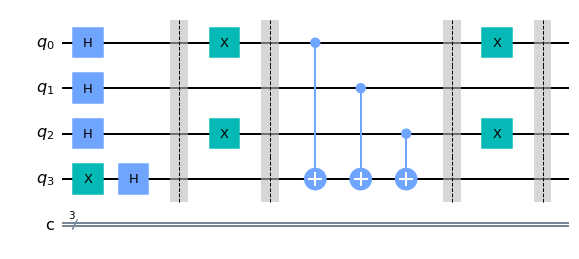

In [15]:
# Generamos el circuito de n+1 qubits y n bits
dj_algo_bal = QuantumCircuit(n+1, n)

#Aplicamos compuertas Hadamard a nuestros qubits de entrada
for qubit in range(n):
    dj_algo_bal.h(qubit)

# Inicializamos nuestro qubit de salida en 1 y aplicamos una compuerta Hadamard
dj_algo_bal.x(n)
dj_algo_bal.h(n)

# Añadimos nuestro oráculo
dj_algo_bal += oraculo_balanceado

dj_algo_bal.draw(output='mpl')

El siguiente paso será volver a aplicar compuertas *Hadamard* a cada uno de los qubits de entrada y tomar mediciones de estos.

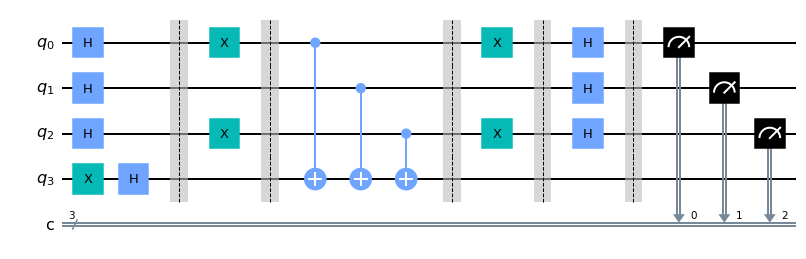

In [16]:
# Aplicamos compuertas Hadamard en los qubits de entrada
for qubit in range(n):
    dj_algo_bal.h(qubit)
dj_algo_bal.barrier()

# Medimos nuestros qubits de entrada
for i in range(n):
    dj_algo_bal.measure(i, i)

# Visualizamos el circuito
dj_algo_bal.draw(output='mpl')

Finalmente podemos simular nuestro circuito para analizar si obtenemos el resultado que queremos. En este caso deberíamos obtener probabilidad cero de medir $000$

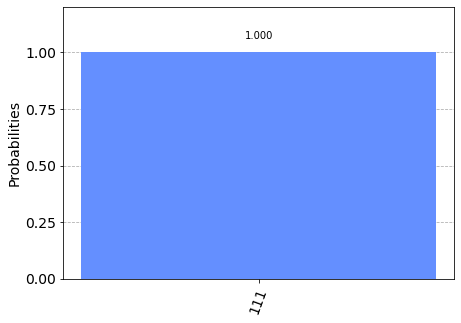

In [17]:
# Simulamos nuestro algoritmo
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(dj_algo_bal, aer_sim)
resultados = aer_sim.run(qobj).result()
respuesta = resultados.get_counts()
plot_histogram(respuesta)

Para el caso del oráculo de una función constante, podemos aplicar el mismo código que aplicamos anteriormente con la diferencia que se agrega el oráculo constante en lugar del balanceado.

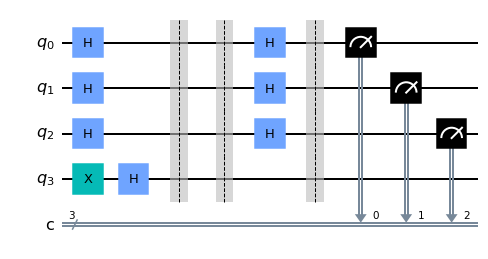

In [18]:
# Generamos el circuito de n+1 qubits y n bits
dj_algo_const = QuantumCircuit(n+1, n)

#Aplicamos compuertas Hadamard a nuestros qubits de entrada
for qubit in range(n):
    dj_algo_const.h(qubit)

# Inicializamos nuestro qubit de salida en 1 y aplicamos una compuerta Hadamard
dj_algo_const.x(n)
dj_algo_const.h(n)

# Añadimos nuestro oráculo constante
dj_algo_const += oraculo_const

# Aplicamos compuertas Hadamard en los qubits de entrada
for qubit in range(n):
    dj_algo_const.h(qubit)
dj_algo_const.barrier()

# Medimos nuestros qubits de entrada
for i in range(n):
    dj_algo_const.measure(i, i)

# Visualizamos el circuito
dj_algo_const.draw(output='mpl')

Finalmente podemos simular nuestro algoritmo y deberíamos obtener $000$ con probabilidad 1

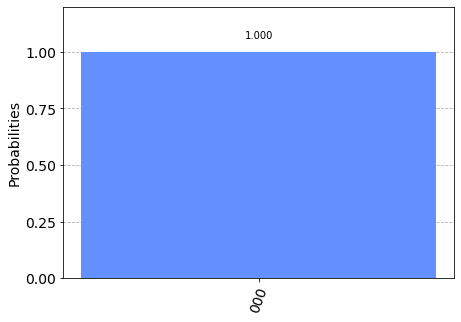

In [19]:
# Simulamos nuestro algoritmo
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(dj_algo_const, aer_sim)
resultados = aer_sim.run(qobj).result()
respuesta = resultados.get_counts()
plot_histogram(respuesta)

<a id="secc4"></a>
# Algoritmo de Grover

El algoritmo de Grover se puede describir como un algorítmo cuántico de búsqueda. La implementación que desarrollaremos en este momento se reduce a un caso simplista. Supongamos que tenemos una función $f(x)$ que toma n bits como argumento de manera que $f(x)=0$ o $f(x)=1$. En este caso, solo existe una cadena de bits $x'$ tal que $f(x')=1$, para el resto de entradas $f(x)=0$. El algoritmo de Grover nos va a ayudar a determinar ese $\ket{x'}$.

Empecemos con un sistema de n qubits y podemos aplicar n compuertas Hadamard para generar estados de superposición. Podemos definir $\ket{\psi}$ como la superposición de todos los posibles estados $\ket{x}$, es decir:

$$\ket{\psi} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} \ket{x} $$

Si separamos el estado $\ket{x'}$ de $\ket{\psi}$ se puede definir $\ket{\psi '} $ tal que:

$$ \ket{\psi '} = \frac{1}{\sqrt{2^n -1}} \sum_{x \in \{ 0,1\}^n, x\neq x'} \ket{x} $$

Podemos definir el operador $U_f$ tal que:

$$ U_f = \sum_{x \in \{ 0,1\}^n} (-1)^{f(x)} \ket{x} \bra{x} = \sum_{x \in \{ 0,1\}^n} (-1)^{\delta_{x,x'}} \ket{x} \bra{ x} $$

Podemos definir un segundo operador $W = 2\ket{\psi} \bra{\psi} - I$ 

Al aplicar $W$ a $\ket{\psi '}$ y $\ket{x'}$ (Los cálculos completos los puedes revisar en la referencia [1]):

$$ \begin{align*} W\ket{x'} & = \frac{2\sqrt{2^n -1}}{2^n} \ket{\psi '} + \left( \frac{2}{2^n} - 1 \right) \ket{x'} \\ W\ket{\psi '} & =  - \left( \frac{2}{2^n} - 1 \right)  \ket{\psi '} + \frac{2\sqrt{2^n -1}}{2^n} \ket{x'} \end{align*} $$

Si definimos $\sin{\theta} = \frac{2\sqrt{2^n -1}}{2^n}$ 

$$ \begin{align*} W\ket{x'} & = -\cos{\theta} \ket{x'} + \sin{\theta} \ket{\psi '} \\ W\ket{\psi '} & = \sin{\theta} \ket{x'} + \cos{\theta} \ket{\psi '} \end{align*} $$

Podemos definir el operador de Grover como $G = WU_f$ y se tiene:

$$ \begin{align*} G\ket{x'} & = \cos{\theta} \ket{x'} - \sin{\theta} \ket{\psi '} \\ G\ket{\psi '} & = \sin{\theta} \ket{x'} + \cos{\theta} \ket{\psi '} \end{align*} $$

Si aplicamos m veces el operador de Grover tendríamos:

$$ \begin{align*} G^m\ket{x'} & = \cos{m \theta} \ket{x'} - \sin{m \theta} \ket{\psi '} \\ G^m\ket{\psi '} & = \sin{m \theta} \ket{x'} + \cos{m \theta} \ket{\psi '} \end{align*} $$

Notemos que para $m\theta = \frac{\psi}{2}$ tenemos que $G^m \ket{\psi '} = \ket{x'}$ por lo tanto podemos obtener el número de iteraciones que debemos realizar:

$$ \begin{align*} m \theta & = m \frac{2\sqrt{2^n -1}}{2^n} = \frac{\pi}{2} \\  m & \approx \frac{\pi}{4} \sqrt{2^n} \end{align*} $$

Por ejemplo, si se tienen 3 qubits, se deberían realizar 2 iteraciones para obtener un resultado óptimo. Si quieres tener más información de este algoritmo puedes checar el siguiente <a href="https://qiskit.org/textbook/ch-algorithms/grover.htmll">enlace</a>.

<a id="secc4.1"></a>
## Implementación en Qiskit

En este caso vamos a implementar el algoritmo de Grover para 3 qubits. Al igual que con el algoritmo de Deutsch-Jozsa, debemos empezar por generar un oráculo correspondiente al valor que queramos buscar, en este caso $101$ y $110$. Para esto podemos aplicar 2 compuertas *Z* controladas por el último y el segundo qubit y con el primer qubit de objetivo.

In [20]:
# Definimos un circuito de 3 qubits
qc = QuantumCircuit(3)

# Aplicamos las compuertas Z controladas
qc.cz(0, 2)
qc.cz(1, 2)

#Definimos nuestro oráculo como una compuerta
oraculo_3 = qc.to_gate()
oraculo_3.name = "Oráculo"

El siguiente paso va a ser definir nuestro operador de Grover. Empezando por aplicar compuertas *Hadamard* y *X* a cada qubit. Después se aplica una compuerta Z controlada por 2 qubits. Finalmente se aplican compuertas *X* y *Hadamard*.

In [21]:
# Definimos nuestro operador de grover
def grover(nqubits):
    # Definimos un circuito de n qubits
    qc = QuantumCircuit(nqubits)

    # Applicamos la compuerta Hadamard a cada qubit
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Applicamos la compuerta x a cada qubit
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Generamos la compuerta z controlada por 2 qubits
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    # Volvemos a aplicar la compuerta X
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Finalmente aplicamos las compuertas Hadamard
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Definimos el operador de grover como compuerta
    U_s = qc.to_gate()
    U_s.name = "Grover"
    return U_s

Ahora que tenemos nuestras 2 compuertas, podemos implementar nuestro algoritmo. Primero aplicamos compuertas *Hadamard* a cada qubit, seguido por nuestro oráculo y nuestro operador de Grover. Finalmente se toman mediciones de cada uno de los qubits.

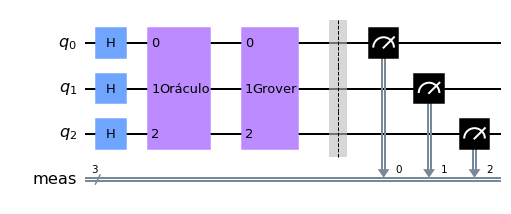

In [22]:
# Definimos el número de qubits
n = 3

#Definimos nuestro circuito de n qubits
circuito_grover = QuantumCircuit(n)

# Aplicamos compuertas Hadamard a cada qubit
for q in range(n):
        circuito_grover.h(q)

# Aplicamos nuestro oráculo
circuito_grover.append(oraculo_3, [0,1,2])

#Aplicamos nuestro operador de Grover
circuito_grover.append(grover(n), [0,1,2])

# Realizamos mediciones
circuito_grover.measure_all()

# Visualizamos nuestro circuito
circuito_grover.draw(output='mpl')

Finalmente podemos simular nuestro circuito para analizar si obtenemos $101$ y $110$ con probabilidad 50/50

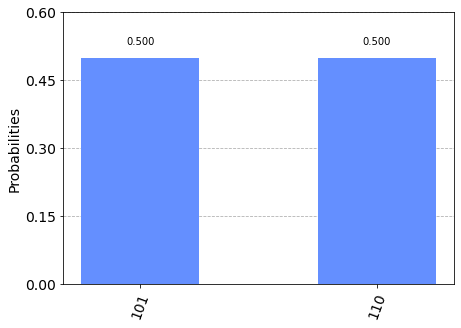

In [23]:
# Simulamos nuestro circuito
aer_sim = Aer.get_backend('aer_simulator')
grover_transpilado = transpile(circuito_grover, aer_sim)
qobj = assemble(grover_transpilado)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

<a id="secc6"></a>
# Referencias

- [1] McMahon, D. (2008). Quantum Computing Explained. Hoboken: John Wiley & Sons. 207-208, 218-221

- [2] Qiskit Development Team. Qiskit Textbook: Quantum teleportation. Consultado en https://qiskit.org/textbook/ch-algorithms/teleportation.html

- [3] Qiskit Development Team. Qiskit Textbook: Superdense Coding. Consultado en https://qiskit.org/textbook/ch-algorithms/superdense-coding.html

- [4] Qiskit Development Team. Qiskit Textbook: Deutsch-Jozsa Algorithm. Consultado en https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html

- [5] Qiskit Development Team. Qiskit Textbook: Grover's Algorithm. Consultado en https://qiskit.org/textbook/ch-algorithms/grover.html


<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="04_qiskit_pulse.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: Qiskit Pulse
            </a>
            </div>
        </td>
    </tr>
</table>